In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, GlobalAveragePooling2D ,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=9.8023e-06)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return ((2*x*(h1))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return ((2 * x * (h2))-(4 * h1)) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return ((2*x*(h3))-(6*h2)) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return ((2*x*(h4))-(8*h3)) / (2**(5/2) * (np.pi**(1/4))*np.sqrt(math.factorial(5)))
    
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

2024-04-22 13:20:19.902223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 13:20:20.381183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

class ResNetHermiteBlock(Layer):
    def __init__(self, filters, stride=1, **kwargs):
        super(ResNetHermiteBlock, self).__init__(**kwargs)
        self.stride = stride
        self.filters = filters
        
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()
        self.h3 = H3Layer()
        self.h4 = H4Layer()
        
        # Initialize Convolutional and Batch Normalization layers
        self.conv1 = Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)
        # self.bn1 = BatchNormalization()
        self.tensorDecomp = TensorDecompositionLayer(3)
        self.conv2 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv3 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv4 = Conv2D(filters, 3, padding="same", use_bias=False)
        # self.bn2 = BatchNormalization()

        # Pre-instantiate the Conv2D layer for shortcut adjustment
        self.shortcut_conv = Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)
        self.shortcut_bn = BatchNormalization()

    def call(self, inputs):
        x = inputs
        
        x = self.conv1(x)
        x = x_h1 = self.h1(x)  # Store H1 output if needed for H2
        x = self.conv2(x)
        # x = self.tensorDecomp(x)
        x = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        x = self.conv3(x)
        # x = self.tensorDecomp(x)
        # x = x_h3 = self.h3(x, x_h1,x_h2)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.conv4(x)
        # x = self.tensorDecomp(x)
        # x = x_h4 = self.h4(x, x_h2,x_h3)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.tensorDecomp(x)
        
        # Conditional application for shortcut
        if self.stride != 1 or inputs.shape[-1] != self.filters:
            shortcut = self.shortcut_conv(inputs)
            shortcut = self.shortcut_bn(shortcut)
        else:
            shortcut = inputs

        x += shortcut
        return x  # Note: You might apply another Hermite activation here if needed

def build_resnet18_hermite(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    # x = H1Layer()(x)  # Starting with an H1 Hermite activation
    # x = layers.ReLU()(x)
    
    # Adding ResNetHermiteBlocks
    x = ResNetHermiteBlock(16, stride=1)(x)
    x = ResNetHermiteBlock(32, stride=1)(x)
    x = ResNetHermiteBlock(64, stride=2)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(256, stride=2)(x)
    # x = ResNetHermiteBlock(256, stride=1)(x)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model = build_resnet18_hermite((32, 32, 3), 10)
model.summary()

2024-03-25 14:22:11.468764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 14:22:11.487541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 14:22:11.487739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 res_net_hermite_block (Res  (None, 32, 32, 16)        14928     
 NetHermiteBlock)                                                
                                                                 
 res_net_hermite_block_1 (R  (None, 32, 32, 32)        23712     
 esNetHermiteBlock)                                              
                                                             

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(x_test, y_test),)
                    # callbacks=[reduce_lr])

import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

# Resnet up to H2 with one layer of Tensor Decomp at the end.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 res_net_hermite_block_4 (R  (None, 32, 32, 16)        12720     
 esNetHermiteBlock)                                              
                                                                 
 res_net_hermite_block_5 (R  (None, 32, 32, 32)        14688     
 esNetHermiteBlock)                                              
                                                           

2024-03-27 11:38:44.714854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-27 11:38:45.649489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-27 11:38:45.650821: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd6000119e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-27 11:38:45.650842: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-27 11:38:45.654401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-27 11:38:45.749217: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

782/782 [==============================] - 20s 16ms/step - loss: 1.7789 - accuracy: 0.3370 - val_loss: 1.7320 - val_accuracy: 0.3631
Epoch 2/100
782/782 [==============================] - 11s 13ms/step - loss: 1.5400 - accuracy: 0.4288 - val_loss: 1.5283 - val_accuracy: 0.4476
Epoch 3/100
782/782 [==============================] - 10s 13ms/step - loss: 1.3965 - accuracy: 0.4920 - val_loss: 1.4605 - val_accuracy: 0.4625
Epoch 4/100
782/782 [==============================] - 10s 13ms/step - loss: 1.3318 - accuracy: 0.5215 - val_loss: 1.3952 - val_accuracy: 0.4905
Epoch 5/100
782/782 [==============================] - 10s 13ms/step - loss: 1.3055 - accuracy: 0.5312 - val_loss: 1.3706 - val_accuracy: 0.5128
Epoch 6/100
782/782 [==============================] - 10s 13ms/step - loss: 1.2299 - accuracy: 0.5610 - val_loss: 1.5511 - val_accuracy: 0.4937
Epoch 7/100
782/782 [==============================] - 10s 13ms/step - loss: 1.2029 - accuracy: 0.5706 - val_loss: 1.1976 - val_accuracy: 0.57

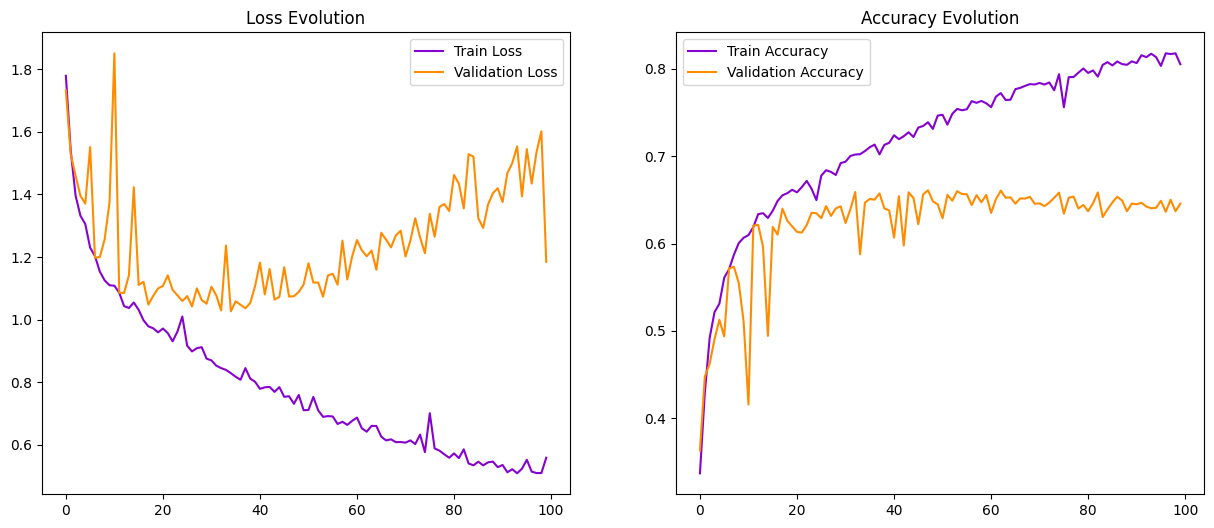

In [3]:

class ResNetHermiteBlock(Layer):
    def __init__(self, filters, stride=1, **kwargs):
        super(ResNetHermiteBlock, self).__init__(**kwargs)
        self.stride = stride
        self.filters = filters
        
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()
        self.h3 = H3Layer()
        self.h4 = H4Layer()
        
        # Initialize Convolutional and Batch Normalization layers
        self.conv1 = Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)
        # self.bn1 = BatchNormalization()
        self.tensorDecomp = TensorDecompositionLayer(3)
        self.conv2 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv3 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv4 = Conv2D(filters, 3, padding="same", use_bias=False)
        # self.bn2 = BatchNormalization()

        # Pre-instantiate the Conv2D layer for shortcut adjustment
        self.shortcut_conv = Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)
        self.shortcut_bn = BatchNormalization()

    def call(self, inputs):
        x = inputs
        
        x = self.conv1(x)
        x = x_h1 = self.h1(x)  # Store H1 output if needed for H2
        x = self.conv2(x)
        # x = self.tensorDecomp(x)
        x = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.conv3(x)
        x = self.tensorDecomp(x)
        # x = x_h3 = self.h3(x, x_h1,x_h2)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.conv4(x)
        # x = self.tensorDecomp(x)
        # x = x_h4 = self.h4(x, x_h2,x_h3)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.tensorDecomp(x)
        
        # Conditional application for shortcut
        if self.stride != 1 or inputs.shape[-1] != self.filters:
            shortcut = self.shortcut_conv(inputs)
            shortcut = self.shortcut_bn(shortcut)
        else:
            shortcut = inputs

        x += shortcut
        return x  # Note: You might apply another Hermite activation here if needed

def build_resnet18_hermite(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    # x = H1Layer()(x)  # Starting with an H1 Hermite activation
    # x = layers.ReLU()(x)
    
    # Adding ResNetHermiteBlocks
    x = ResNetHermiteBlock(16, stride=1)(x)
    x = ResNetHermiteBlock(32, stride=1)(x)
    x = ResNetHermiteBlock(64, stride=2)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(256, stride=2)(x)
    # x = ResNetHermiteBlock(256, stride=1)(x)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model = build_resnet18_hermite((32, 32, 3), 10)
model.summary()
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(x_test, y_test),)
                    # callbacks=[reduce_lr])

import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

# Resnet H2 5 blocks

2024-03-27 12:52:22.028781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 12:52:22.050216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 12:52:22.050393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 res_net_hermite_block (Res  (None, 32, 32, 16)        12784     
 NetHermiteBlock)                                                
                                                                 
 res_net_hermite_block_1 (R  (None, 32, 32, 32)        14816     
 esNetHermiteBlock)                                              
                                                             

2024-03-27 12:52:27.096600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-27 12:52:27.975663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-27 12:52:27.977600: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e3be990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-27 12:52:27.977622: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-27 12:52:27.983969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-27 12:52:28.090339: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 20s 16ms/step - loss: 1.7074 - accuracy: 0.3702 - val_loss: 1.6636 - val_accuracy: 0.3973
Epoch 2/100
782/782 [==============================] - 11s 14ms/step - loss: 1.3960 - accuracy: 0.4999 - val_loss: 1.2766 - val_accuracy: 0.5425
Epoch 3/100
782/782 [==============================] - 11s 14ms/step - loss: 1.2474 - accuracy: 0.5538 - val_loss: 1.5674 - val_accuracy: 0.4664
Epoch 4/100
782/782 [==============================] - 11s 14ms/step - loss: 1.1856 - accuracy: 0.5810 - val_loss: 1.2206 - val_accuracy: 0.5721
Epoch 5/100
782/782 [==============================] - 11s 14ms/step - loss: 1.0875 - accuracy: 0.6167 - val_loss: 1.0606 - val_accuracy: 0.6258
Epoch 6/100
782/782 [==============================] - 11s 14ms/step - loss: 1.1435 - accuracy: 0.6062 - val_loss: 1.2007 - val_accuracy: 0.5751
Epoch 7/100
782/782 [==============================] - 11s 14ms/step - loss: 1.0942 - accuracy: 0.6152 - val_loss: 1.1752 - val_accuracy: 0.58

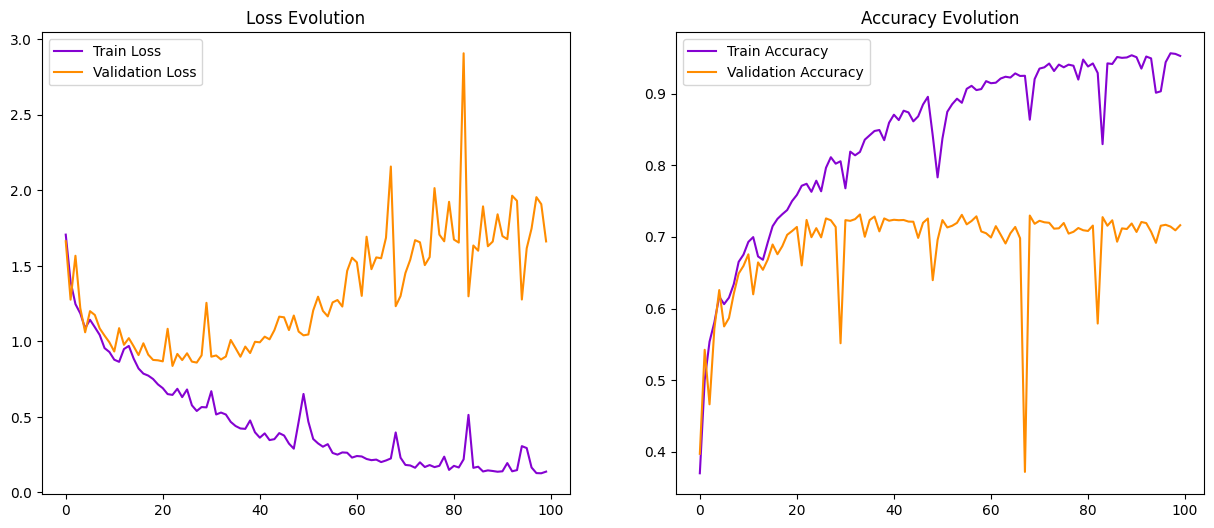

In [2]:

class ResNetHermiteBlock(Layer):
    def __init__(self, filters, stride=1, **kwargs):
        super(ResNetHermiteBlock, self).__init__(**kwargs)
        self.stride = stride
        self.filters = filters
        
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()
        # self.h3 = H3Layer()
        # self.h4 = H4Layer()
        
        # Initialize Convolutional and Batch Normalization layers
        self.conv1 = Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)
        # self.bn1 = BatchNormalization()
        self.tensorDecomp = TensorDecompositionLayer(5)
        self.conv2 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv3 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv4 = Conv2D(filters, 3, padding="same", use_bias=False)
        # self.bn2 = BatchNormalization()

        # Pre-instantiate the Conv2D layer for shortcut adjustment
        self.shortcut_conv = Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)
        self.shortcut_bn = BatchNormalization()

    def call(self, inputs):
        x = inputs
        
        x = self.conv1(x)
        x = x_h1 = self.h1(x)  # Store H1 output if needed for H2
        x = self.conv2(x)
        # x = self.tensorDecomp(x)
        x = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.conv3(x)
        x = self.tensorDecomp(x)
        # x = x_h3 = self.h3(x, x_h1,x_h2)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.conv4(x)
        # x = self.tensorDecomp(x)
        # x = x_h4 = self.h4(x, x_h2,x_h3)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.tensorDecomp(x)
        
        # Conditional application for shortcut
        if self.stride != 1 or inputs.shape[-1] != self.filters:
            shortcut = self.shortcut_conv(inputs)
            shortcut = self.shortcut_bn(shortcut)
        else:
            shortcut = inputs

        x += shortcut
        return x  # Note: You might apply another Hermite activation here if needed

def build_resnet18_hermite(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    # x = H1Layer()(x)  # Starting with an H1 Hermite activation
    # x = layers.ReLU()(x)
    
    # Adding ResNetHermiteBlocks
    x = ResNetHermiteBlock(16, stride=1)(x)
    x = ResNetHermiteBlock(32, stride=1)(x)
    x = ResNetHermiteBlock(64, stride=2)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(256, stride=2)(x)
    # x = ResNetHermiteBlock(256, stride=1)(x)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model = build_resnet18_hermite((32, 32, 3), 10)
model.summary()
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(x_test, y_test),)
                    # callbacks=[reduce_lr])

import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

# K = 6

In [2]:

class ResNetHermiteBlock(Layer):
    def __init__(self, filters, stride=1, **kwargs):
        super(ResNetHermiteBlock, self).__init__(**kwargs)
        self.stride = stride
        self.filters = filters
        
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()
        # self.h3 = H3Layer()
        # self.h4 = H4Layer()
        
        # Initialize Convolutional and Batch Normalization layers
        self.conv1 = Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)
        # self.bn1 = BatchNormalization()
        self.tensorDecomp = TensorDecompositionLayer(6)
        self.conv2 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv3 = Conv2D(filters, 3, padding="same", use_bias=False)
        self.conv4 = Conv2D(filters, 3, padding="same", use_bias=False)
        # self.bn2 = BatchNormalization()

        # Pre-instantiate the Conv2D layer for shortcut adjustment
        self.shortcut_conv = Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)
        self.shortcut_bn = BatchNormalization()

    def call(self, inputs):
        x = inputs
        
        x = self.conv1(x)
        x = x_h1 = self.h1(x)  # Store H1 output if needed for H2
        x = self.conv2(x)
        # x = self.tensorDecomp(x)
        x = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.conv3(x)
        x = self.tensorDecomp(x)
        # x = x_h3 = self.h3(x, x_h1,x_h2)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.conv4(x)
        # x = self.tensorDecomp(x)
        # x = x_h4 = self.h4(x, x_h2,x_h3)  # Pass x_h1 as the additional argument to H2Layer
        # x = self.tensorDecomp(x)
        
        # Conditional application for shortcut
        if self.stride != 1 or inputs.shape[-1] != self.filters:
            shortcut = self.shortcut_conv(inputs)
            shortcut = self.shortcut_bn(shortcut)
        else:
            shortcut = inputs

        x += shortcut
        return x  # Note: You might apply another Hermite activation here if needed

def build_resnet18_hermite(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    # x = H1Layer()(x)  # Starting with an H1 Hermite activation
    # x = layers.ReLU()(x)
    
    # Adding ResNetHermiteBlocks
    x = ResNetHermiteBlock(16, stride=1)(x)
    x = ResNetHermiteBlock(32, stride=1)(x)
    x = ResNetHermiteBlock(64, stride=2)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    # x = ResNetHermiteBlock(256, stride=2)(x)
    # x = ResNetHermiteBlock(256, stride=1)(x)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model = build_resnet18_hermite((32, 32, 3), 10)
model.summary()
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(x_test, y_test),)
                    # callbacks=[reduce_lr])

import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

2024-04-01 13:12:30.098500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 13:12:30.119055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 13:12:30.119300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 res_net_hermite_block (Res  (None, 32, 32, 16)        12816     
 NetHermiteBlock)                                                
                                                                 
 res_net_hermite_block_1 (R  (None, 32, 32, 32)        14880     
 esNetHermiteBlock)                                              
                                                             

KeyboardInterrupt: 

## Modified RESNET 18
https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras

In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers
# Adding TF Cifar10 Data ..
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)


"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResNetHermiteBlock(Model):
    """
    A HERMITE resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        self.tensorDecomp = TensorDecompositionLayer(3)
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        # x = self.bn_1(x)
        x = x_h1 = self.h1(x)  # Store H1 output if needed for H2
        # x = tf.nn.relu(x)
        x = self.conv_2(x)
        # x = self.bn_2(x)
        x = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        x = self.tensorDecomp(x)


        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        out = self.merge([x, res])
        # out = tf.nn.relu(x)
        # x_h1 = self.h1(x)  # Store H1 output if needed for H2
        # out = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        # out = self.tensorDecomp(x)

        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResNetHermiteBlock(64)
        self.res_1_2 = ResNetHermiteBlock(64)
        self.res_2_1 = ResNetHermiteBlock(128, down_sample=True)
        self.res_2_2 = ResNetHermiteBlock(128)
        self.res_3_1 = ResNetHermiteBlock(256, down_sample=True)
        self.res_3_2 = ResNetHermiteBlock(256)
        self.res_4_1 = ResNetHermiteBlock(512, down_sample=True)
        self.res_4_2 = ResNetHermiteBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        # out = tf.nn.relu(out)
        out = self.pool_2(out)

        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
        # for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2 ,self.res_4_1]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) #LR = 0.001
model.summary()
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 64
# history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])
history = model.fit(aug.flow(X_train,Y_train,batch_size = 64), steps_per_epoch=STEPS, batch_size = 64, epochs=50, validation_data=(X_train, Y_train))

2024-04-11 14:19:09.726170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-11 14:19:09.743983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 14:19:09.744179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 14:19:09.746112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_net_hermite_block (Res  multiple                  74304     
 NetHermiteBlock)                                                
                                                                 
 res_net_hermite_block_1 (R  multiple                  74304     
 esNetHermiteBlock)                                      

2024-04-11 14:19:14.501629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-11 14:19:15.269380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-11 14:19:15.270998: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb19000df30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-11 14:19:15.271028: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-11 14:19:15.276824: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 14:19:15.376120: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

625/625 [==============================] - 23s 21ms/step - loss: 1.6909 - accuracy: 0.3896 - val_loss: 1.5535 - val_accuracy: 0.4446
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3827 - accuracy: 0.5046 - val_loss: 1.4349 - val_accuracy: 0.5252
Epoch 3/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2424 - accuracy: 0.5572 - val_loss: 1.2018 - val_accuracy: 0.5738
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - loss: 1.1430 - accuracy: 0.5922 - val_loss: 1.0870 - val_accuracy: 0.6194
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 1.0537 - accuracy: 0.6288 - val_loss: 1.1158 - val_accuracy: 0.6176
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.9924 - accuracy: 0.6490 - val_loss: 1.1729 - val_accuracy: 0.6080
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.9373 - accuracy: 0.6716 - val_loss: 0.9079 - val_accuracy: 0.6823
Epo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


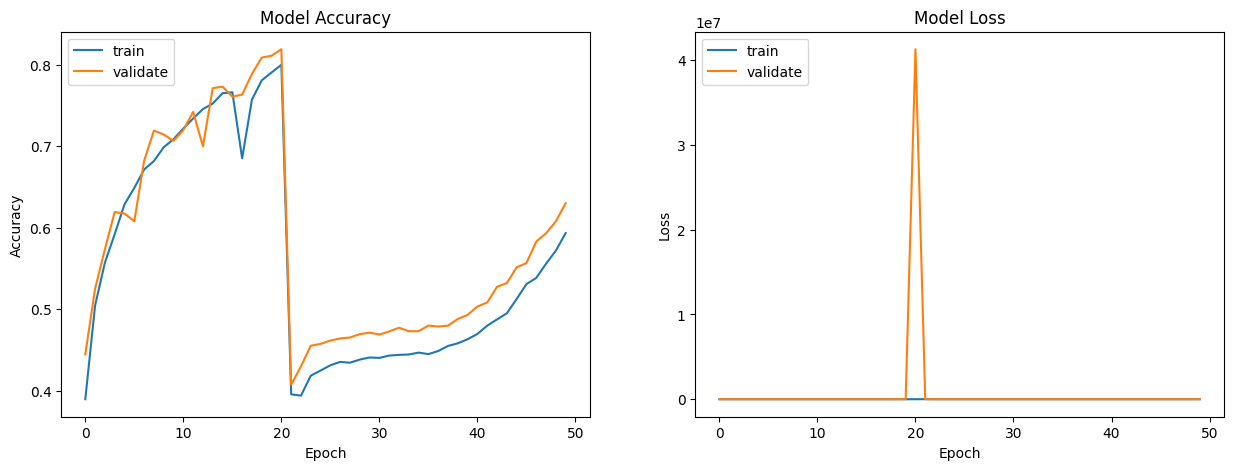

: 

In [3]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)


# Resnet 18 with hermite up to h4

In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers
# Adding TF Cifar10 Data ..
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)


"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResNetHermiteBlock(Model):
    """
    A HERMITE resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        self.tensorDecomp = TensorDecompositionLayer(3)
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()
        self.h3 = H3Layer()
        self.h4 = H4Layer()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs, hermite_level, h_a, h_b):
        res = inputs
        if hermite_level == 1:
            x = self.conv_1(inputs)
            x = x_h1 = self.h1(x)  # Store H1 output if needed for H2
            x = self.conv_2(x)
            x = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
            # x = self.tensorDecomp(x)
            h_a = x_h1
            h_b = x_h2

        elif hermite_level == 2:
            x = self.conv_1(inputs)
            x_h1 = h_a
            x_h2 = h_b
            x = x_h3 = self.h3(x,x_h1,x_h2)  # Pass x_h1 as the additional argument to H2Layer
            x = self.conv_2(x)
            # x = self.bn_2(x)
            x = x_h4 = self.h4(x,x_h2,x_h3)  # Pass x_h1 as the additional argument to H2Layer
            # x = self.tensorDecomp(x)
            h_a = x_h3
            h_b = x_h4


        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        out = self.merge([x, res])
        # out = tf.nn.relu(x)
        # x_h1 = self.h1(x)  # Store H1 output if needed for H2
        # out = x_h2 = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        # out = self.tensorDecomp(x)

        return out, h_a, h_b


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResNetHermiteBlock(64)
        self.res_1_2 = ResNetHermiteBlock(64)
        self.res_2_1 = ResNetHermiteBlock(128, down_sample=True)
        self.res_2_2 = ResNetHermiteBlock(128)
        self.res_3_1 = ResNetHermiteBlock(256, down_sample=True)
        self.res_3_2 = ResNetHermiteBlock(256)
        self.res_4_1 = ResNetHermiteBlock(512, down_sample=True)
        self.res_4_2 = ResNetHermiteBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        # out = tf.nn.relu(out)
        out = self.pool_2(out)

        out,h1,h2 = self.res_1_1(out,1,out,out)
        out,h3,h4 = self.res_1_2(out,2,h1,h2)

        # for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
        # # for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2 ,self.res_4_1]:
        #     out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


model = ResNet18(10)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) #LR = 0.001
model.summary()
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 64
# history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])
history = model.fit(aug.flow(X_train,Y_train, batch_size = 64), steps_per_epoch=STEPS, batch_size = 64, epochs=50, validation_data=(X_train, Y_train))

2024-04-22 13:20:21.821268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_net_hermite_block (Res  multiple          

2024-04-22 13:20:21.838476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 13:20:21.838666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 13:20:21.840589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 esNetHermiteBlock)                                              
                                                                 
 res_net_hermite_block_7 (R  multiple                  0 (unused)
 esNetHermiteBlock)                                              
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  650       
                                                                 
Total params: 158154 (617.79 KB)
Trainable params: 158026 (617.29 KB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________
Epoch 1/50


2024-04-22 13:20:24.423899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-22 13:20:25.003217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-22 13:20:25.004719: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3d9800dbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 13:20:25.004748: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-22 13:20:25.010668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 13:20:25.112728: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

625/625 [==============================] - 15s 18ms/step - loss: 1.7213 - accuracy: 0.3801 - val_loss: 1.6144 - val_accuracy: 0.4050
Epoch 2/50
625/625 [==============================] - 11s 18ms/step - loss: 1.4078 - accuracy: 0.4941 - val_loss: 2.0059 - val_accuracy: 0.4124
Epoch 3/50
625/625 [==============================] - 11s 18ms/step - loss: 1.2738 - accuracy: 0.5466 - val_loss: 1.4091 - val_accuracy: 0.4998
Epoch 4/50
625/625 [==============================] - 11s 17ms/step - loss: 1.1892 - accuracy: 0.5806 - val_loss: 1.1016 - val_accuracy: 0.6148
Epoch 5/50
625/625 [==============================] - 11s 18ms/step - loss: 1.1114 - accuracy: 0.6068 - val_loss: 1.0645 - val_accuracy: 0.6202
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 1.0672 - accuracy: 0.6273 - val_loss: 1.1465 - val_accuracy: 0.5952
Epoch 7/50
625/625 [==============================] - 11s 17ms/step - loss: 1.0084 - accuracy: 0.6467 - val_loss: 1.3144 - val_accuracy: 0.5825
Epo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


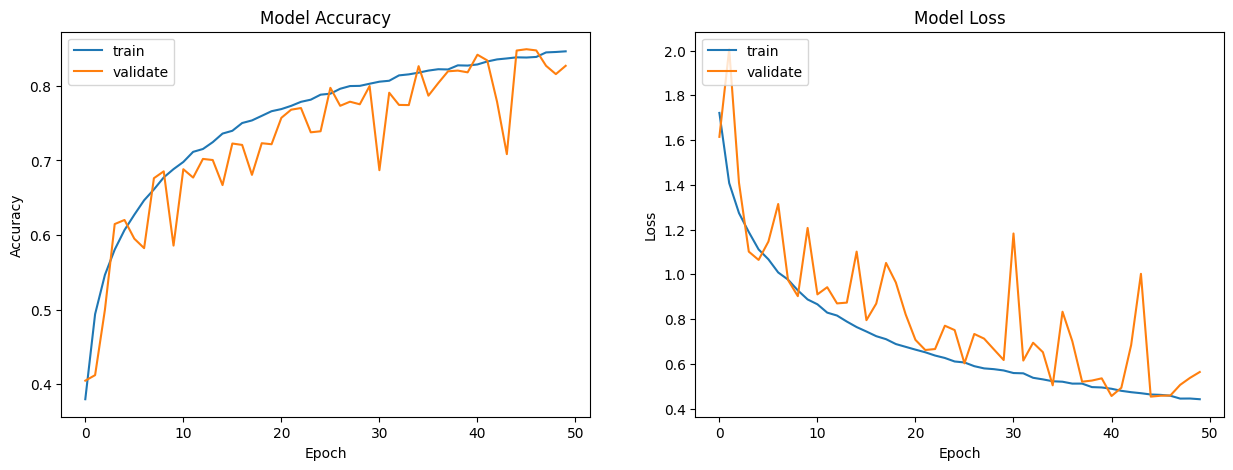

In [3]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)
